In [1]:
import torch
import numpy as np

In [2]:
from utils.make_data import autoregressive
# from models.conformal import nonconformity, cover, ConformalForecaster

In [126]:
def generate_autoregressive_forecast_dataset(n_samples=100,
                                             seq_len=100,
                                             n_features=1,
                                             X_mean=1,
                                             X_variance=2,
                                             noise_profile=None,
                                             memory_factor=0.9,
                                             mode="time-dependent",
                                             horizon=10):
    total_seq_len = seq_len + horizon
    # Create the input features of the generating process
    X_gen = [np.random.normal(X_mean, X_variance, (total_seq_len,
                                                   n_features))
             for _ in range(n_samples)]
    w = np.array([memory_factor ** k for k in range(total_seq_len)])

    if noise_profile is None:
        # default increasing noise profile
        noise_profile = np.array(
            [1 / (seq_len - 1) * k for k in range(total_seq_len)])

    X = None  # X stores the time series values generated from features X_gen
    if mode == "noise-sweep":
        X = torch.FloatTensor(
            [[(autoregressive(X_gen[k], w).reshape(total_seq_len, n_features) +
               np.random.normal(0, noise_profile[u], (total_seq_len,
                                                      n_features)))
                  .reshape(total_seq_len, ) for k in range(n_samples)]
             for u in range(len(noise_profile))])


    elif mode == "time-dependent":
        X = torch.FloatTensor(
            [(autoregressive(X_gen[k], w)
              .reshape(total_seq_len, n_features) + (
                  torch.normal(mean=0.0, std=torch.tensor(noise_profile)))
              .detach().numpy().reshape(-1, n_features)).reshape(
                total_seq_len, )
                for k in range(n_samples)])

    # TODO clean up (un)squeezing.
    Y = torch.FloatTensor(X[:, -horizon:])  # `horizon` of predictions
    X = torch.nn.utils.rnn.pad_sequence(X[:, :-horizon],
                                        batch_first=True).unsqueeze(dim=-1)
    
    print(X.size(), Y.size())

    dataset = torch.utils.data.TensorDataset(X, Y)
    return dataset


In [153]:
import numpy as np
import torch
from torch import nn


def nonconformity(output, target):
    """Measures the nonconformity between output and target time series."""
    # Average MAE loss for every step in the sequence.
    return torch.nn.functional.l1_loss(output, target, reduction='none')


def cover(pred, target):
    # Returns True when the entire forecast fits into predicted conformal
    # intervals.
    # TODO joint vs independent coverage
    return torch.all(
        torch.logical_and(target >= pred[:, 0], target <= pred[:, 1])).item()


class ConformalForecaster(nn.Module):
    def __init__(self, embedding_size, input_size=1, output_size=1, horizon=1,
                 error_rate=0.05):
        super(ConformalForecaster, self).__init__()
        # input_size indicates the number of features in the time series
        # input_size=1 for univariate series.

        # Encoder and forecaster can be the same (if embeddings are
        # trained on `horizon`-step forecasts), but different models are
        # possible.

        # TODO try separate encoder and forecaster models.
        # TODO try the RNN autoencoder trained on reconstruction error.
        self.encoder = None

        self.forecaster_rnn = nn.LSTM(input_size=input_size,
                                      hidden_size=embedding_size,
                                      batch_first=True)
        self.forecaster_out = nn.Linear(embedding_size, output_size)

        self.horizon = horizon
        self.alpha = error_rate

        self.num_train = None
        self.calibration_scores = None
        self.critical_calibration_scores = None

    def forward(self, x, len_x):
        # len_x : torch.LongTensor
        # 		  Length of sequences (b, )
        sorted_len, idx = len_x.sort(dim=0, descending=True)
        sorted_x = x[idx]

        # Convert to packed sequence batch
        packed_x = torch.nn.utils.rnn.pack_padded_sequence(sorted_x,
                                                           lengths=sorted_len,
                                                           batch_first=True)

        # [batch, seq_len, embedding_size]
        packed_h, _ = self.forecaster_rnn(packed_x)

        max_seq_len = x.size(1)
        padded_output, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_h,
                                                                  batch_first=True,
                                                                  total_length=max_seq_len)

        _, reverse_idx = idx.sort(dim=0, descending=False)
        padded_output = padded_output[reverse_idx]

        # [batch, horizon, output_size, 1]
        return self.forecaster_out(
            padded_output[:, -self.horizon:, :]).unsqueeze(-1)

    def fit(self, dataset, calibration_dataset, epochs, lr, batch_size=150):
        # Train the forecaster to return correct multi-step predictions.
        train_loader = torch.utils.data.DataLoader(dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)
        self.num_train = len(dataset)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = torch.nn.MSELoss()

        for epoch in range(epochs):
            self.train()
            train_loss = 0.

            for sequences, targets in train_loader:  # iterate through batches
                optimizer.zero_grad()

                out = self(sequences)

                loss = criterion(out, targets)
                loss.backward()

                train_loss += loss.item()

                optimizer.step()

            mean_train_loss = train_loss / len(train_loader)
            if epoch % 50 == 0:
                print(
                    'Epoch: {}\tTrain loss: {}'.format(epoch, mean_train_loss))

        # Collect calibration scores
        self.calibrate(calibration_dataset)

    def calibrate(self, calibration_dataset):
        """
        Computes the nonconformity scores for the calibration dataset.
        """
        calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                                         batch_size=1)
        calibration_scores = []

        with torch.set_grad_enabled(False):
            self.eval()
            for sequences, targets in calibration_loader:
                out = self(sequences)
                calibration_scores.extend(
                    nonconformity(out, targets).detach().numpy())

        self.calibration_scores = torch.tensor(calibration_scores).T

        # Given p_{z}:=\frac{\left|\left\{i=m+1, \ldots, n+1: R_{i} \geq R_{n+1}\right\}\right|}{n-m+1}
        # and the accepted R_{n+1} = \Delta(y, f(x_{test})) are such that
        # p_{z} > \alpha we have that the nonconformity scores should be below
        # the (corrected) (1 - alpha)% of calibration scores.

        # TODO check: By applying (3) to Zcal, we get the sequence of
        # non-conformity scores and then sort them in descending order
        # α1, . . . , αq. Then, depending on the significance level ε, we define
        # the index of the (1 − ε)-percentile non-conformity score, αs, such as
        # s = ⌊ε(q + 1)⌋.
        self.critical_calibration_scores = torch.tensor([np.quantile(
            position_calibration_scores, q=1 - self.alpha * self.num_train / (
                    self.num_train + 1))
            for position_calibration_scores in self.calibration_scores])

    def predict(self, x):
        """Forecasts the time series with conformal uncertainty intervals."""
        out = self(x).squeeze()
        # TODO +/- nonconformity will not return *adaptive* interval widths.
        # TODO correction for multiple comparisons for each multi-horizon step.
        return torch.vstack([out - self.critical_calibration_scores,
                             out + self.critical_calibration_scores]).T


In [127]:
train_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=10)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=100, horizon=10)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=100, seq_len=100, horizon=10)

torch.Size([1000, 100, 1]) torch.Size([1000, 10])
torch.Size([1000, 100, 1]) torch.Size([1000, 10])
torch.Size([100, 100, 1]) torch.Size([100, 10])


In [ ]:
# X: [n_samples, max_seq_len, n_features]
# Y: [n_samples, horizon]

In [6]:
model = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05)

In [7]:
model.fit(train_dataset, calibration_dataset, epochs=10, lr=0.01, batch_size=100)

TypeError: forward() missing 1 required positional argument: 'len_x'

In [42]:
model.critical_calibration_scores

tensor([9.4111, 9.8009, 9.6471, 9.4183, 9.5524, 9.5123, 9.4077, 9.2933, 9.5192,
        9.4380], dtype=torch.float64)

In [46]:
model.eval()
c = []
for sequence, target in test_dataset:
    sequence = sequence.unsqueeze(dim=0)
    pred = model.predict(sequence)
    c.append(cover(pred, target))
print('Achieved coverage: {}'.format(np.mean(c)))

Achieved coverage: 0.77


In [45]:
def cover(pred, target):
    # Returns True when the entire forecast fits into predicted conformal
    # intervals.
    return torch.all(
        torch.logical_and(target >= pred[:, 0], target <= pred[:, 1])).item()

In [37]:
for sequence, target in test_dataset:
    sequence = sequence.unsqueeze(dim=0)
    h, _ = model.forecaster_rnn(sequence)
    print(h.size())
    # [batch, horizon, output_size, 1]
    out = model.forecaster_out(h[:, -10:, :]).unsqueeze(-1)
    print(out.size())
    print(model.critical_calibration_scores.size())
    print(out.squeeze().size())
    
    break

torch.Size([1, 100, 8])
torch.Size([1, 10, 1, 1])
torch.Size([10])
torch.Size([10])


In [164]:
alpha = 0.05
num_train = 1000

def calibrate(calibration_dataset):
    """
    Computes the nonconformity scores for the calibration dataset.
    """
    calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                                     batch_size=1)
    calibration_scores = []

    with torch.set_grad_enabled(False):
        model.eval()
        for sequences, targets in calibration_loader:
            out = model(sequences)
            calibration_scores.extend(nonconformity(out, targets).detach().numpy())

    calibration_scores = torch.tensor(calibration_scores).T

    # Given p_{z}:=\frac{\left|\left\{i=m+1, \ldots, n+1: R_{i} \geq R_{n+1}\right\}\right|}{n-m+1}
    # and the accepted R_{n+1} = \Delta(y, f(x_{test})) are such that
    # p_{z} > \alpha we have that the nonconformity scores should be below
    # the (corrected) alpha% of calibration scores.
    critical_calibration_scores = torch.tensor([np.quantile(
        position_calibration_scores, q= alpha * num_train / (num_train + 1))
        for position_calibration_scores in calibration_scores])
    print(critical_calibration_scores)

In [165]:
calibrate(calibration_dataset)

tensor([0.1335, 0.2231, 0.2458, 0.2786, 0.2465, 0.2878, 0.3393, 0.3049, 0.2977,
        0.3465], dtype=torch.float64)


In [176]:
1 - alpha * num_train / (num_train + 1)

0.9500499500499501

In [133]:
import numpy as np

def autoregressive(X_gen, w):
    """ Generates a single time series example. """
    return np.array(
        [np.sum(X_gen[0:k + 1] * np.flip(w[0:k + 1]).reshape(-1, 1)) for k in
         range(len(X_gen))])


seq_len = 10
horizon = 10
n_samples = 100
X_mean = 1
X_variance = 2
n_features = 1
memory_factor = 0.9

# sequence_lengths = [seq_len + horizon] * n_samples
sequence_lengths = range(horizon + 1, n_samples + horizon + 1)
max_seq_len = np.max(sequence_lengths)

# Create the input features of the generating process
X_gen = [np.random.normal(X_mean, X_variance, (seq_len,
                                               n_features))
         for seq_len in sequence_lengths]

# TODO determine how do weights and noise profile change depending on the
# length of series.
w = np.array([memory_factor ** k for k in range(max_seq_len)])

In [134]:
noise_profiles = [[1 / (seq_len - 1) * k for k in range(max(1, seq_len))] for seq_len in sequence_lengths]

In [84]:
X_gen[2].shape

(13, 1)

In [135]:
noise = [np.random.normal(0., noise_profile).reshape(-1, n_features) for noise_profile in noise_profiles]

In [136]:
ar = [autoregressive(X_gen[k], w).reshape(sequence_lengths[k], n_features) for k in range(n_samples)]

In [137]:
X_full = [torch.tensor(i + j) for i, j in zip(ar, noise)]

In [138]:
len(X_full)

100

In [139]:
X[0].shape

torch.Size([1, 1])

In [90]:
[autoregressive(X_gen[k], w).reshape(-1, n_features) for k in range(n_samples)][0].shape

(11, 1)

In [92]:
X_full = X

In [278]:
X, Y = [], []
for seq in X_full:
    seq_len = len(seq)
    if seq_len >= 2 * horizon:
        X.append(seq[:-horizon])
        Y.append(seq[-horizon:])
    elif seq_len > horizon:
        X.append(seq[:seq_len - horizon])
        Y.append(seq[-(seq_len - horizon):])

In [143]:
# for x in X:
print(len(X[99]))

100


In [281]:
horizon

10

In [144]:
for i in range(len(X)):
    print('X_full: {}\tX: {}\tY: {}'.format(len(X_full[i]), len(X[i]), len(Y[i])))

X_full: 11	X: 1	Y: 1
X_full: 12	X: 2	Y: 2
X_full: 13	X: 3	Y: 3
X_full: 14	X: 4	Y: 4
X_full: 15	X: 5	Y: 5
X_full: 16	X: 6	Y: 6
X_full: 17	X: 7	Y: 7
X_full: 18	X: 8	Y: 8
X_full: 19	X: 9	Y: 9
X_full: 20	X: 10	Y: 10
X_full: 21	X: 11	Y: 10
X_full: 22	X: 12	Y: 10
X_full: 23	X: 13	Y: 10
X_full: 24	X: 14	Y: 10
X_full: 25	X: 15	Y: 10
X_full: 26	X: 16	Y: 10
X_full: 27	X: 17	Y: 10
X_full: 28	X: 18	Y: 10
X_full: 29	X: 19	Y: 10
X_full: 30	X: 20	Y: 10
X_full: 31	X: 21	Y: 10
X_full: 32	X: 22	Y: 10
X_full: 33	X: 23	Y: 10
X_full: 34	X: 24	Y: 10
X_full: 35	X: 25	Y: 10
X_full: 36	X: 26	Y: 10
X_full: 37	X: 27	Y: 10
X_full: 38	X: 28	Y: 10
X_full: 39	X: 29	Y: 10
X_full: 40	X: 30	Y: 10
X_full: 41	X: 31	Y: 10
X_full: 42	X: 32	Y: 10
X_full: 43	X: 33	Y: 10
X_full: 44	X: 34	Y: 10
X_full: 45	X: 35	Y: 10
X_full: 46	X: 36	Y: 10
X_full: 47	X: 37	Y: 10
X_full: 48	X: 38	Y: 10
X_full: 49	X: 39	Y: 10
X_full: 50	X: 40	Y: 10
X_full: 51	X: 41	Y: 10
X_full: 52	X: 42	Y: 10
X_full: 53	X: 43	Y: 10
X_full: 54	X: 44	Y: 10
X_full

In [277]:
len(X_full)

100

In [100]:
len(X_gen)

7

In [279]:
X_tensor = torch.nn.utils.rnn.pad_sequence(X, batch_first=True).float()

In [149]:
X_tensor.size()

torch.Size([100, 100, 1])

In [280]:
Y_tensor = torch.nn.utils.rnn.pad_sequence(Y, batch_first=True).float()

In [151]:
Y_tensor.size()

torch.Size([100, 10, 1])

In [ ]:
# X: [n_samples, max_seq_len, n_features]
# Y: [n_samples, horizon]

In [155]:
torch.LongTensor(sequence_lengths).size()

torch.Size([100])

In [158]:
torch.utils.data.TensorDataset(X_tensor, Y_tensor)

In [159]:
class AutoregressiveForecastDataset(torch.utils.data.Dataset):
    """Synthetic autoregressive forecast dataset."""

    def __init__(self, X, Y, sequence_lengths):
        super(AutoregressiveForecastDataset, self).__init__()
        self.X = X
        self.Y = Y
        self.sequence_lengths = sequence_lengths

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx], self.sequence_lengths[idx]

In [189]:
train_dataset = AutoregressiveForecastDataset(X_tensor, Y_tensor, sequence_lengths)

In [161]:
train_dataset

In [220]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=32,shuffle=False)
train_loader

In [221]:
for sequences, targets, lengths in train_loader:
    print(sequences, lengths)
    break

tensor([[[ 1.9074],
         [ 0.0000],
         [ 0.0000],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 2.7737],
         [ 2.2558],
         [ 0.0000],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 2.3862],
         [ 4.2745],
         [ 4.8667],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        ...,

        [[-1.7812],
         [ 0.2619],
         [-1.1253],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[-0.4307],
         [ 0.2517],
         [ 3.6385],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 1.1731],
         [-0.9770],
         [ 0.1760],
         ...,
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]]]) tensor([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28,
        29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42])


In [250]:
sorted_len, idx = lengths.sort(dim=0, descending=True)
sorted_x = sequences[idx]

# Convert to packed sequence batch
packed_x = torch.nn.utils.rnn.pack_padded_sequence(sorted_x,
                                                   lengths=sorted_len,
                                                   batch_first=True)

In [251]:
packed_h, _ = model.forecaster_rnn(packed_x.float())

In [252]:
max_seq_len = sequences.size(1)
padded_out, _ = torch.nn.utils.rnn.pad_packed_sequence(packed_h,
                                                       batch_first=True,
                                                       total_length=max_seq_len)

_, reverse_idx = idx.sort(dim=0, descending=False)
padded_out = padded_out[reverse_idx]

In [253]:
padded_out.size()

torch.Size([32, 100, 8])

In [254]:
out2 = model.forecaster_out(padded_out[:, -horizon:, :])
out2.size()

torch.Size([32, 10, 1])

In [172]:
model = model.float()

In [198]:
model = ConformalForecaster(embedding_size=8, horizon=10, error_rate=0.05).float()

In [256]:
out, _ = model.forecaster_rnn(sequences.float())
out1 = model.forecaster_out(out[:, -model.horizon:, :])

In [257]:
out1.size()

torch.Size([32, 10, 1])

In [258]:
targets.size()

torch.Size([32, 10, 1])

In [259]:
out1[0]

tensor([[0.0559],
        [0.0559],
        [0.0559],
        [0.0559],
        [0.0559],
        [0.0559],
        [0.0559],
        [0.0559],
        [0.0559],
        [0.0559]], grad_fn=<SelectBackward>)

In [255]:
out2[0]

tensor([[0.0459],
        [0.0459],
        [0.0459],
        [0.0459],
        [0.0459],
        [0.0459],
        [0.0459],
        [0.0459],
        [0.0459],
        [0.0459]], grad_fn=<SelectBackward>)

In [249]:
targets

tensor([[[10.6410],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 5.5729],
         [ 9.7845],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[11.3683],
         [13.7080],
         [13.8089],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 3.0774],
         [ 6.5124],
         [ 8.7384],
         [10.0974],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000]],

        [[ 7.6234],
         [ 5.8028],
         [ 4.2828],
         [ 5.1974],
         [ 7.1386],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0.0000],
         [ 0

In [261]:
lengths

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18,
        19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32])

In [272]:
targets.size()

torch.Size([32, 10, 1])

In [268]:
lengths_mask = torch.zeros(targets.size())

In [269]:
for i, l in enumerate(lengths):
    lengths_mask[i, :min(l, horizon), :] = 1

In [273]:
torch.nn.functional.mse_loss(lengths_mask * out2, targets)

tensor(96.5020, grad_fn=<MseLossBackward>)

In [276]:
torch.nn.functional.mse_loss(torch.tensor([1.,2.,3.]), torch.tensor([1.,0.,3.]))

tensor(1.3333)

In [271]:
lengths_mask * out2

tensor([[[0.0459],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0459],
         [0.0459],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0459],
         [0.0459],
         [0.0459],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0459],
         [0.0459],
         [0.0459],
         [0.0459],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0459],
         [0.0459],
         [0.0459],
         [0.0459],
         [0.0459],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000],
         [0.0000]],

        [[0.0459],
         [0.0459],
  

In [181]:
class ConformalForecaster(torch.nn.Module):
    def __init__(self, embedding_size, input_size=1, output_size=1, horizon=1,
                 error_rate=0.05):
        super(ConformalForecaster, self).__init__()
        # input_size indicates the number of features in the time series
        # input_size=1 for univariate series.

        # Encoder and forecaster can be the same (if embeddings are
        # trained on `horizon`-step forecasts), but different models are
        # possible.

        # TODO try separate encoder and forecaster models.
        # TODO try the RNN autoencoder trained on reconstruction error.
        self.encoder = None

        self.forecaster_rnn = torch.nn.LSTM(input_size=input_size,
                                            hidden_size=embedding_size,
                                            batch_first=True)
        self.forecaster_out = torch.nn.Linear(embedding_size, output_size)

        self.horizon = horizon
        self.alpha = error_rate

        self.n_train = None
        self.calibration_scores = None
        self.critical_calibration_scores = None

    def forward(self, x):
        
        out = self.forecaster_rnn(x)
        # [batch, horizon, output_size, 1]
        out = self.forecaster_out(
            out[:, -self.horizon:, :]).unsqueeze(-1)

        return out

    def fit(self, dataset, calibration_dataset, epochs, lr, batch_size=150):
        # Train the forecaster to return correct multi-step predictions.
        train_loader = torch.utils.data.DataLoader(dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True)
        self.n_train = len(dataset)

        optimizer = torch.optim.Adam(self.parameters(), lr=lr)
        criterion = torch.nn.MSELoss()

        self.train()
        for epoch in range(epochs):
            train_loss = 0.

            # Iterate through batches.
            for sequences, targets, lengths in train_loader:
                optimizer.zero_grad()

                out = self(sequences, lengths)

                loss = criterion(out, targets)
                loss.backward()

                train_loss += loss.item()

                optimizer.step()

            mean_train_loss = train_loss / len(train_loader)
            if epoch % 50 == 0:
                print(
                    'Epoch: {}\tTrain loss: {}'.format(epoch, mean_train_loss))

        # Collect calibration scores
        self.calibrate(calibration_dataset)

    def calibrate(self, calibration_dataset):
        """
        Computes the nonconformity scores for the calibration dataset.
        """
        calibration_loader = torch.utils.data.DataLoader(calibration_dataset,
                                                         batch_size=1)
        calibration_scores = []

        with torch.set_grad_enabled(False):
            self.eval()
            for sequences, targets in calibration_loader:
                out = self(sequences)
                calibration_scores.extend(
                    nonconformity(out, targets).detach().numpy())

        self.calibration_scores = torch.tensor(calibration_scores).T

        # Given p_{z}:=\frac{\left|\left\{i=m+1, \ldots, n+1: R_{i} \geq R_{n+1}\right\}\right|}{n-m+1}
        # and the accepted R_{n+1} = \Delta(y, f(x_{test})) are such that
        # p_{z} > \alpha we have that the nonconformity scores should be below
        # the (corrected) (1 - alpha)% of calibration scores.

        # TODO check: By applying (3) to Zcal, we get the sequence of
        # non-conformity scores and then sort them in descending order
        # α1, . . . , αq. Then, depending on the significance level ε, we define
        # the index of the (1 − ε)-percentile non-conformity score, αs, such as
        # s = ⌊ε(q + 1)⌋.
        self.critical_calibration_scores = torch.tensor([np.quantile(
            position_calibration_scores, q=1 - self.alpha * self.n_train / (
                    self.n_train + 1))
            for position_calibration_scores in self.calibration_scores])

    def predict(self, x):
        """Forecasts the time series with conformal uncertainty intervals."""
        out = self(x).squeeze()
        # TODO +/- nonconformity will not return *adaptive* interval widths.
        # TODO correction for multiple comparisons for each multi-horizon step.
        return torch.vstack([out - self.critical_calibration_scores,
                             out + self.critical_calibration_scores]).T


In [194]:
model.forecaster_rnn(sequences)

RuntimeError: expected scalar type Double but found Float

In [185]:
sequences.size()

torch.Size([32, 100, 1])

In [282]:
z = np.random.geometric(p=0.35, size=10000)

In [283]:
z

array([1, 2, 5, ..., 2, 1, 1])

In [284]:
z + 5

array([ 6,  7, 10, ...,  7,  6,  6])

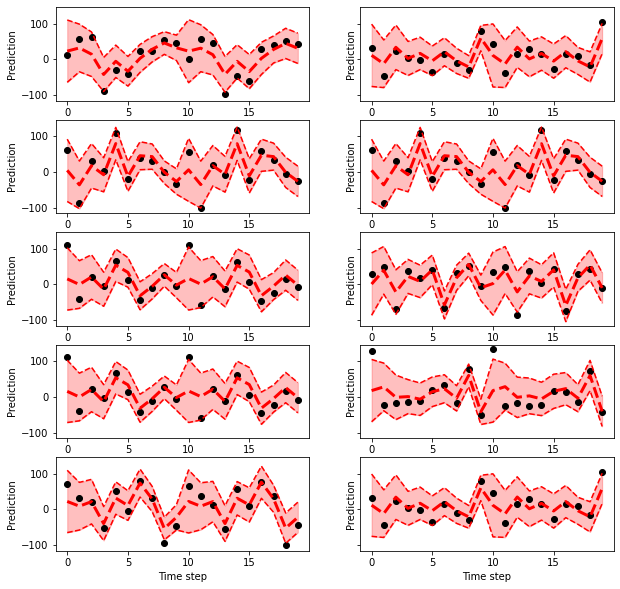

In [788]:
plot_miscoverage_examples(test_dataset, coverages, intervals)

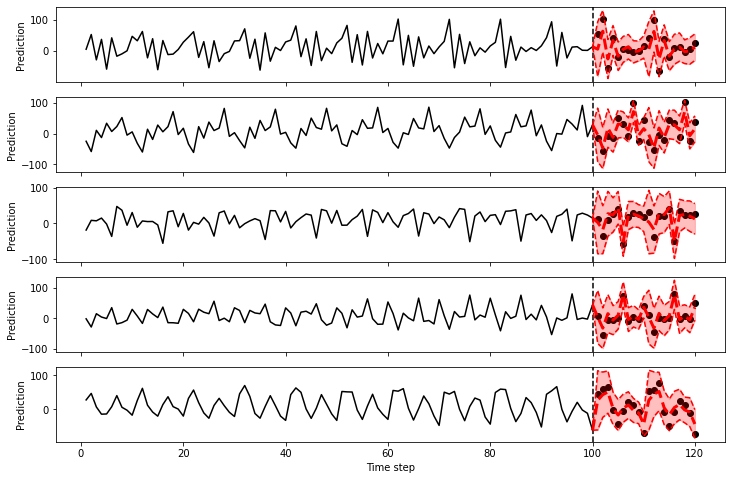

In [790]:
plot_ts(test_dataset, coverages, intervals)

## Shorter training intervals

In [946]:
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

seq_len = 10
horizon = 5
noise_profile = [0.1 * k for k in range(seq_len + horizon)]
periodicity = 2
amplitude = 1
dynamic_sequence_lengths=False

epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

In [958]:
train_dataset = generate_autoregressive_forecast_dataset(n_samples=n_train_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
calibration_dataset = generate_autoregressive_forecast_dataset(n_samples=n_calibration_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)
test_dataset = generate_autoregressive_forecast_dataset(n_samples=n_test_samples, 
                                                               seq_len=seq_len, 
                                                               horizon=horizon, 
                                                               periodicity=periodicity,
                                                               noise_profile=noise_profile, 
                                                               amplitude=amplitude,
                                                               dynamic_sequence_lengths=dynamic_sequence_lengths)

In [959]:
from models.conformal import ConformalForecaster
model = ConformalForecaster(embedding_size=embedding_size, horizon=horizon, error_rate=1-coverage)

In [960]:
model.fit(train_dataset, calibration_dataset, epochs=epochs, lr=lr, batch_size=batch_size)
coverages, intervals = model.evaluate_coverage(test_dataset)
print('% of series within predicted intervals: {}'.format(torch.mean(coverages.float(), dim=0).item()))

Epoch: 0	Train loss: 101.74006881713868
Epoch: 50	Train loss: 15.947912693023682
Epoch: 100	Train loss: 13.019464206695556
Epoch: 150	Train loss: 10.88747034072876
Epoch: 200	Train loss: 9.595336532592773
Epoch: 250	Train loss: 8.929739952087402
Epoch: 300	Train loss: 8.436613273620605
Epoch: 350	Train loss: 8.158452081680299
Epoch: 400	Train loss: 8.004016256332397
Epoch: 450	Train loss: 7.153136396408081
Epoch: 500	Train loss: 7.233106899261474
Epoch: 550	Train loss: 7.076313400268555
Epoch: 600	Train loss: 7.010235548019409
Epoch: 650	Train loss: 7.181740140914917
Epoch: 700	Train loss: 7.470318269729614
Epoch: 750	Train loss: 7.12489161491394
Epoch: 800	Train loss: 8.133337926864623
Epoch: 850	Train loss: 6.486271667480469
Epoch: 900	Train loss: 7.811726856231689
Epoch: 950	Train loss: 6.3441839694976805
% of series within predicted intervals: 0.9319999814033508


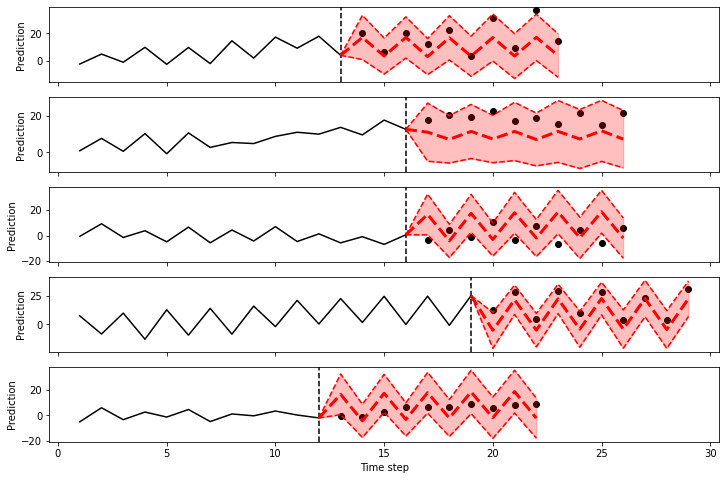

In [961]:
miscovered_idx_short = torch.nonzero(~coverages_short, as_tuple=False)[:, 0].tolist()
plot_ts(test_dataset_short, coverages_short, intervals_short, idx=miscovered_idx_short)

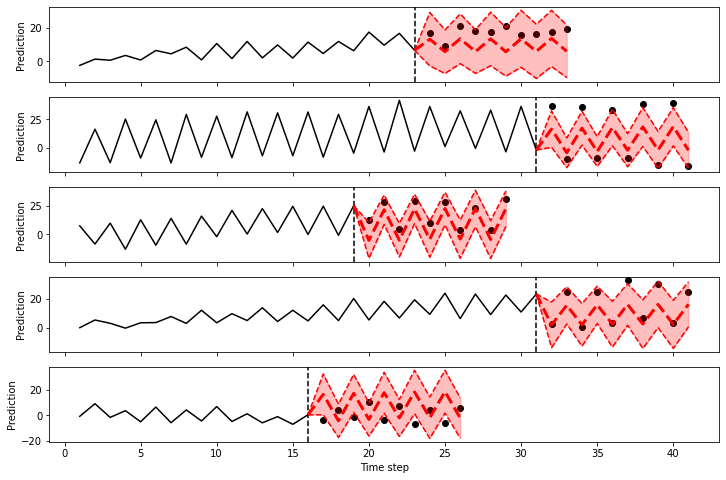

In [962]:
plot_ts(test_dataset_short, coverages_short, intervals_short, idx=miscovered_idx_short)

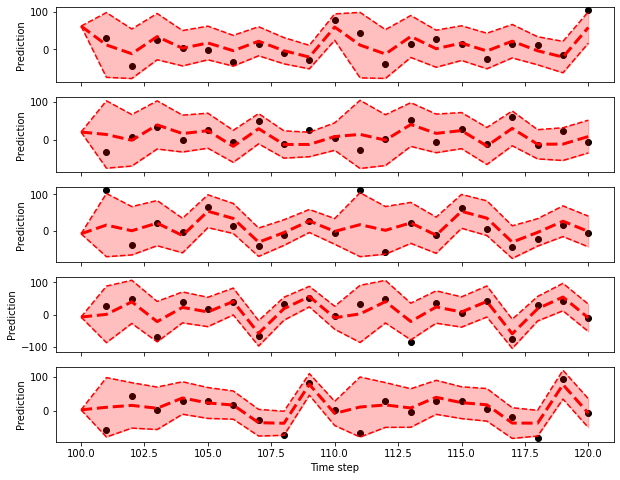

In [732]:
miscovered_idx = torch.nonzero(~coverages, as_tuple=False)[:, 0].tolist()
plot_ts(test_dataset, coverages, intervals, idx=miscovered_idx, forecast_only=True)

## Dynamic sequence lengths

In [903]:
from utils.make_data import generate_autoregressive_forecast_dataset
train_dataset_dyn = generate_autoregressive_forecast_dataset(n_samples=100, seq_len=20, horizon=10, periodicity=3, dynamic_sequence_lengths=True)
calibration_dataset_dyn = generate_autoregressive_forecast_dataset(n_samples=1000, seq_len=20, horizon=10, periodicity=3, dynamic_sequence_lengths=True)
test_dataset_dyn = generate_autoregressive_forecast_dataset(n_samples=500, seq_len=20, horizon=10, periodicity=3, dynamic_sequence_lengths=True)

In [932]:
from models.conformal import ConformalForecaster
model_dyn = ConformalForecaster(embedding_size=20, horizon=10, error_rate=0.05)

In [933]:
model_dyn.fit(train_dataset_dyn, calibration_dataset_dyn, epochs=5000, lr=0.01, batch_size=100)
coverages_dyn, intervals_dyn = model_dyn.evaluate_coverage(test_dataset_dyn)


Epoch: 0	Train loss: 163.5849151611328
Epoch: 50	Train loss: 79.95691680908203
Epoch: 100	Train loss: 79.71898651123047
Epoch: 150	Train loss: 79.71536254882812
Epoch: 200	Train loss: 79.71528625488281
Epoch: 250	Train loss: 79.71524810791016
Epoch: 300	Train loss: 79.71521759033203
Epoch: 350	Train loss: 79.71520233154297
Epoch: 400	Train loss: 79.71517181396484
Epoch: 450	Train loss: 79.71514892578125
Epoch: 500	Train loss: 79.71513366699219
Epoch: 550	Train loss: 79.71511840820312
Epoch: 600	Train loss: 79.71509552001953
Epoch: 650	Train loss: 79.715087890625
Epoch: 700	Train loss: 79.7150650024414
Epoch: 750	Train loss: 79.71504211425781
Epoch: 800	Train loss: 79.71501922607422
Epoch: 850	Train loss: 79.71499633789062
Epoch: 900	Train loss: 79.7149658203125
Epoch: 950	Train loss: 79.7149429321289
Epoch: 1000	Train loss: 79.71492004394531
Epoch: 1050	Train loss: 79.71488189697266
Epoch: 1100	Train loss: 79.71485137939453
Epoch: 1150	Train loss: 79.71481323242188
Epoch: 1200	Train lo

In [911]:
print('% of series within predicted intervals: {}'.format(torch.mean(coverages_dyn.float(), dim=0).item()))

% of series within predicted intervals: 0.9620000123977661


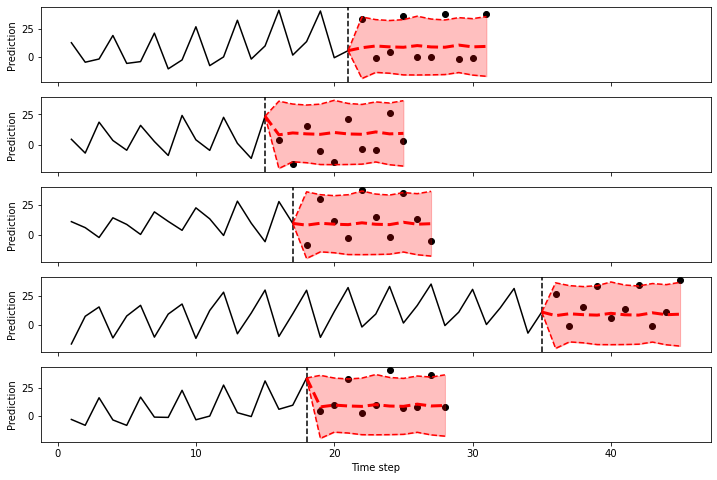

In [912]:
miscovered_idx_dyn = torch.nonzero(~coverages_dyn, as_tuple=False)[:, 0].tolist()
plot_ts(test_dataset_dyn, coverages_dyn, intervals_dyn, idx=miscovered_idx_dyn)

In [285]:
plot_ts(test_dataset_dyn, coverages_dyn, intervals_dyn)

NameError: name 'plot_ts' is not defined

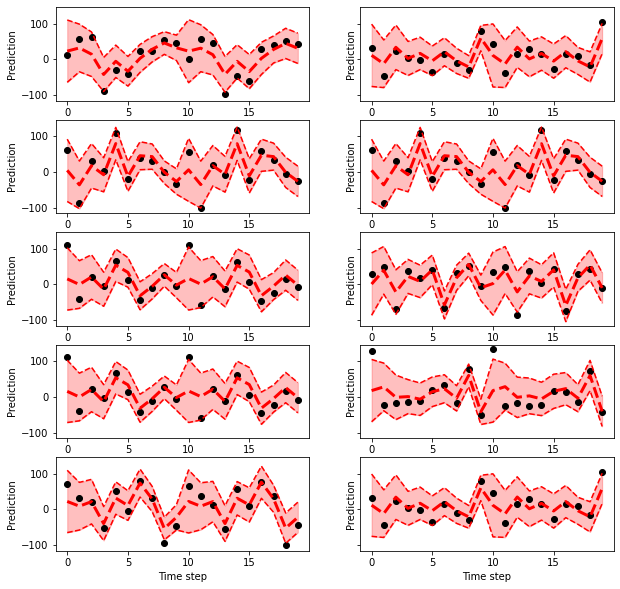

In [788]:
plot_miscoverage_examples(test_dataset, coverages, intervals)

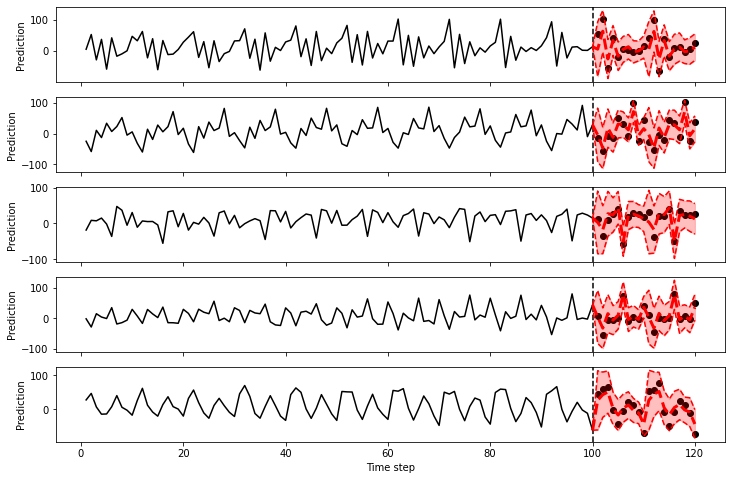

In [790]:
plot_ts(test_dataset, coverages, intervals)

In [287]:
from utils.make_data import generate_autoregressive_forecast_dataset
from utils.train_conformal import train_conformal_forecaster

# Dataset size
n_train_samples = 1000
n_calibration_samples = 1000
n_test_samples = 500

# Time series parameters
seq_len = 10
horizon = 5
noise_profile = None
periodicity = None
amplitude = 1
dynamic_sequence_lengths=False

# LSTM parameters
epochs=1000
batch_size=100
embedding_size=20
coverage=0.9
lr=0.01

results_time_dependent_noise_no_periodic = []
for i in range(1, 6):
    noise_profile = [0.1 * k * i for k in range(seq_len + horizon)]
    result = train_conformal_forecaster(noise_profile=noise_profile)
    print('Model {}:\tcoverage: {}\twidths: {}'.format(i, result['mean_coverage'], result['interval_widths']))
    results_time_dependent_noise_no_periodic.append(result)

TypeError: generate_autoregressive_forecast_dataset() got an unexpected keyword argument 'periodicity'

In [1]:
import numpy as np

In [3]:
lst = [np.array([1,2,4]), np.array([3,5])]

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(np.array(lst))

/Users/kamilestankeviciute/anaconda3/envs/aml/lib/python3.7/site-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: setting an array element with a sequence.

In [7]:
np.concatenate(lst)

array([1, 2, 4, 3, 5])

In [8]:
import pickle

In [9]:
with open('data/mimic.p', 'rb') as f:
        MIMIC_data = pickle.load(f)

Y = MIMIC_data["longitudinal"][:, :, 23]  # 'wbchigh'
L = MIMIC_data['trajectory_lengths']

In [10]:
perm = np.random.RandomState(seed=0).permutation(400)
train_idx = perm[:40]

scaler = StandardScaler()
scaler.fit(Y[np.where(L > 4)[0]][train_idx])

StandardScaler()

In [12]:
Y[np.where(L > 4)[0]][train_idx].shape

(40, 50)

In [23]:
from utils.data_processing_mimic import get_mimic_splits
get_mimic_splits(cached=False, conformal=False)

(([array([2.45645329, 2.68552102, 3.09457053, 3.43817213]),
   array([2.08012773, 0.72208333, 0.4930156 , 0.3293958 , 0.3293958 ,
          0.68935937]),
   array([2.57098715, 2.40736734, 2.66915904, 1.85106   , 2.39100536,
          2.1946616 , 1.85106   , 2.1946616 , 1.75288812, 2.83277884,
          2.89822676, 2.55462517, 3.04548459, 2.701883  , 2.06376575,
          1.13113285, 1.14749483, 1.36020058, 1.18021879, 1.03296097]),
   array([-0.0960157 ,  0.18213797, -0.03056778, -0.16146362, -0.11237768,
          -0.07965372, -0.04692976]),
   array([2.73460696, 2.71824498, 3.74904976, 3.83085966, 4.20718522,
          3.87994561, 4.40352899, 4.27263314, 3.48725807, 3.91266957,
          4.35444305, 3.24182836, 3.01276063, 2.99639865, 2.58734913,
          2.32555744, 3.25819034, 3.3727242 , 3.47089609, 3.22546638,
          3.56906797]),
   array([0.39484372, 0.42756768, 0.36211976, 0.31303382, 3.2091044 ,
          2.57098715, 1.72016416, 0.28030986, 0.10032807, 0.05124213,
       

In [14]:
%load_ext autoreload
%autoreload 2

In [22]:
from utils.data_processing_eeg import get_eeg_splits
get_eeg_splits(cached=False, conformal=False)

((array([[-0.86277735, -0.06762571, -0.45677941, ..., -0.92506752,
          -1.35489217, -1.98893749],
         [-0.60469114,  0.66713811,  0.01543507, ..., -0.67808966,
          -1.12407777, -1.74722859],
         [-0.49898417,  0.09639078,  0.00530613, ..., -0.60224437,
          -0.80470256, -1.33489053],
         ...,
         [-0.38267623, -0.67675486, -0.03772365, ..., -0.05248999,
           0.14346575,  0.05812165],
         [ 0.29287048,  0.86466499,  0.91091867, ...,  0.47823233,
           0.51946039,  0.02131413],
         [ 0.3987841 ,  0.3135122 ,  1.12150073, ...,  0.18788646,
           0.10375727, -0.50094004]]),
  array([[-17.62451882, -14.22137251, -24.01886735, ..., -12.48718514,
          -17.10292799, -29.16658822],
         [-13.60878929,  -6.60520503, -18.88069719, ...,  -6.54846201,
          -13.47150531, -26.19589387],
         [-14.58158546, -11.81014528, -19.80232335, ..., -10.37765954,
          -18.62930932, -21.11294931],
         ...,
         [ -2.76

In [24]:
import pandas as pd

In [25]:
df = pd.read_csv('data/ltla_2021-05-24.csv')

In [26]:
df

,areaCode,areaName,areaType,date,newCasesByPublishDate
0,E06000003,Redcar and Cleveland,ltla,2021-05-24,8
1,E07000040,East Devon,ltla,2021-05-24,1
2,E07000090,Havant,ltla,2021-05-24,1
3,E07000214,Surrey Heath,ltla,2021-05-24,0
4,E07000229,Worthing,ltla,2021-05-24,0
...,...,...,...,...,...
145711,E07000084,Basingstoke and Deane,ltla,2020-04-22,13
145712,E07000128,Wyre,ltla,2020-04-22,8
145713,E07000176,Rushcliffe,ltla,2020-04-22,5
145714,E07000218,North Warwickshire,ltla,2020-04-22,4


In [29]:
df['areaCode'].nunique()

380

In [30]:
df2 = pd.read_csv('data/utla_2021-05-24.csv')

In [31]:
df2['areaCode'].nunique()

214